**<font size="5">Applied Statistics</font>**

<font size="3">MSc in High Performance Computing Engineering, Computer Science and Engineering, Physics Engineering - A.Y. 2024-2025</font>

Prof. Mario Beraha - Dott. Vittorio Torri

---

<font size="4">**Lab 8 - Variable Selection, Cross Validation, Regularized Models**</font>

# Libraries

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import statsmodels.api as sm

In [ ]:
np.random.seed(1234)

In [ ]:
import scipy.stats as stats

# Load Dataset

In [ ]:
df = pd.read_csv('heart_failure_clinical_records_dataset_smhd.csv')

In [ ]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,bmi
0,75.00,0,582,0,20.73,1,265000.00,1.90,138.39,Male,0,4,True,30.82
1,55.00,0,7861,0,29.02,0,263358.03,1.10,131.90,Male,0,6,True,25.40
2,65.00,0,146,0,26.24,0,162000.00,1.30,143.66,Male,1,7,True,29.45
3,50.00,1,111,0,10.21,0,210000.00,1.90,135.03,Male,0,7,True,36.06
4,65.00,1,160,1,19.33,0,327000.00,2.70,136.08,Female,0,8,True,33.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.00,0,61,1,38.05,1,155000.00,1.10,135.58,Male,1,270,False,25.60
295,55.00,0,1820,0,35.20,0,270000.00,1.20,142.02,Female,0,271,False,29.39
296,45.00,0,2060,1,62.32,0,742000.00,0.80,136.38,Female,0,278,False,20.71
297,45.00,0,2413,0,37.49,0,140000.00,1.40,133.91,Male,1,280,False,27.76


In [ ]:
cat_vars = ['anaemia', 'diabetes', 'high_blood_pressure',  'sex',  'smoking',  'DEATH_EVENT']
num_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'bmi', 'time']#, 'rehospitalizations']

# Feature selection

## Linear Regression for ejection fraction

In [ ]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import ExhaustiveFeatureSelector

# Prepare data
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time',
        'DEATH_EVENT']] #all the variables involved
y = df['ejection_fraction']

numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing (Scaling numerical var, one hot encoder for categorical)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test) #mean and std dev of the TRAINING set
feature_names = preprocessor.get_feature_names_out()
n = len(y_test)

print("le dimensioni del dataset di training completo sonp: ",X_train_proc.shape)

# Helper for metrics computation
def get_model_stats(y_true, y_pred, p, mse_full):
    rss = np.sum((y_true - y_pred) ** 2)
    mse = rss / len(y_true)
    aic = n * np.log(mse) + 2 * p
    bic = n * np.log(mse) + p * np.log(n)
    cp = rss / mse_full - n + 2 * p
    return aic, bic, cp

# Full model (OLS)
start = time.time()
ols_model = LinearRegression().fit(X_train_proc, y_train)
train_rss_full = np.sum((y_train - ols_model.predict(X_train_proc)) ** 2)
mse_full = train_rss_full / len(y_train)
y_pred_ols = ols_model.predict(X_test_proc)
aic_ols, bic_ols, cp_ols = get_model_stats(y_test, y_pred_ols, X_test_proc.shape[1] + 1, mse_full)
time_ols = time.time() - start

# Best Subset Selection => I compare all the possible models according to all possible sets of variables (2^P)
#You need to provide the score to compare all the models.We measure the performance of the model on the VALIDATION set (actually we are doing CROSS VALIDATION)
#In cross validation we use K-1 folds to do both variable selection and training, and the last fold to evaluate the reduced model ypu have obtained
start = time.time()
efs = ExhaustiveFeatureSelector(LinearRegression(), min_features=1, max_features=10, scoring='r2', cv=5)
efs.fit(X_train_proc, y_train)
best_subset_idx = list(efs.best_idx_)
model_best = LinearRegression().fit(X_train_proc[:, best_subset_idx], y_train)
y_pred_best = model_best.predict(X_test_proc[:, best_subset_idx])
aic_best, bic_best, cp_best = get_model_stats(y_test, y_pred_best, len(best_subset_idx) + 1, mse_full)
time_best = time.time() - start


#GREEDY HEURISTICS:
# Forward Selection: Starting from 1 Variable (Bj) and picking the one with the best performance and i add it, then i repeat by adding a new variable
#Once you have selected a variable to be added you can't remove it from your model.
start = time.time()
sfs_forward = SequentialFeatureSelector(LinearRegression(), direction='forward', cv=5, scoring='r2')
sfs_forward.fit(X_train_proc, y_train)
fmask = sfs_forward.get_support()
model_fwd = LinearRegression().fit(X_train_proc[:, fmask], y_train)
y_pred_fwd = model_fwd.predict(X_test_proc[:, fmask])
aic_fwd, bic_fwd, cp_fwd = get_model_stats(y_test, y_pred_fwd, sum(fmask) + 1, mse_full)
time_fwd = time.time() - start

# Backward Elimination: Starting from the full model and eliminating one variable at time.
# IF p > n YOU CANT DO BACKWARD SELECTION
# if p is really high, you cant fit the model due to computational aspect of matrices

#    Parti con tutte le feature.

    #Consideri, una per una, cosa succede se ne rimuovi una. Usi cross-validation per vedere quanto il tuo modello è capace a predirre.

    #Per ogni rimozione possibile:

        #Fai cross-validation (CV) con le feature senza quella specifica da voler rimuovere.

        #Da ogni K-1 fold estrai il r2 valutato su k fold(validation set) e calcoli la media di tutti i R² ottenuti sui fold di CV → chiamiamolo R² medio.

    #Confronti tutti gli R² medi ottenuti rimuovendo una feature alla volta.

    #Togli la feature la cui rimozione dà il miglior (più alto) R² medio.

start = time.time()
sfs_backward = SequentialFeatureSelector(LinearRegression(), direction='backward', cv=5, scoring='r2')
sfs_backward.fit(X_train_proc, y_train)
bmask = sfs_backward.get_support()
model_bwd = LinearRegression().fit(X_train_proc[:, bmask], y_train)
y_pred_bwd = model_bwd.predict(X_test_proc[:, bmask])
aic_bwd, bic_bwd, cp_bwd = get_model_stats(y_test, y_pred_bwd, sum(bmask) + 1, mse_full)
time_bwd = time.time() - start

# Compile metrics
metrics_df = pd.DataFrame([
    {'Model': 'OLS (All)', 'AIC': aic_ols, 'BIC': bic_ols, "Cp": cp_ols, 'Time (s)': time_ols},
    {'Model': 'Best Subset', 'AIC': aic_best, 'BIC': bic_best, "Cp": cp_best, 'Time (s)': time_best},
    {'Model': 'Forward Selection', 'AIC': aic_fwd, 'BIC': bic_fwd, "Cp": cp_fwd, 'Time (s)': time_fwd},
    {'Model': 'Backward Selection', 'AIC': aic_bwd, 'BIC': bic_bwd, "Cp": cp_bwd, 'Time (s)': time_bwd}
])


# Display
print("\n\nModel Comparison (AIC, BIC, Cp, Time):")
print(metrics_df)

print("\nSelected Features:")
print('Best subset:\n')
print(feature_names[best_subset_idx])
print('\nForward selection:\n')
print(feature_names[fmask])
print('\nBackward selection:\n')
print(feature_names[bmask])


#0 is the complete model
#1 is the Best subset
#...

le dimensioni del dataset di training completo sonp:  (239, 13)


Features: 8099/8099



Model Comparison (AIC, BIC, Cp, Time):
                Model    AIC    BIC    Cp  Time (s)
0           OLS (All) 284.16 313.49 34.99      0.03
1         Best Subset 266.14 274.52 17.24    119.28
2   Forward Selection 270.79 285.45 21.69      4.65
3  Backward Selection 271.87 288.62 22.66      2.32

Selected Features:
Best subset:

['num__serum_creatinine' 'num__bmi' 'cat__DEATH_EVENT_True']

Forward selection:

['num__age' 'num__platelets' 'num__serum_creatinine' 'num__serum_sodium'
 'num__bmi' 'cat__DEATH_EVENT_True']

Backward selection:

['num__age' 'num__platelets' 'num__serum_creatinine' 'num__serum_sodium'
 'num__bmi' 'cat__sex_Male' 'cat__DEATH_EVENT_True']


## Logistic Regression for Death

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Target
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time', 'ejection_fraction'
        ]]
y = df['DEATH_EVENT']

# Feature groups
numeric_vars = num_vars.copy()
categorical_vars = cat_vars.copy()
categorical_vars.remove('DEATH_EVENT')  # remove target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
n = len(y_test)

# Fit full logistic model
start = time.time()
logreg_full = LogisticRegression(max_iter=1000).fit(X_train_proc, y_train)
y_pred_full = logreg_full.predict(X_test_proc)
y_proba_full = logreg_full.predict_proba(X_test_proc)[:, 1]
logloss_full = log_loss(y_test, y_proba_full)
time_full = time.time() - start

# AIC/BIC for logistic
def get_classification_metrics(y_true, y_prob, model, p, n):
    ll = -log_loss(y_true, y_prob, normalize=False)
    aic = 2 * p - 2 * ll
    bic = p * np.log(n) - 2 * ll
    r2_mcf = 1 - (ll / LogisticRegression().fit(np.ones((n,1)), y_true).score(np.ones((n,1)), y_true))  # pseudo R²
    return aic, bic, r2_mcf

aic_full, bic_full, r2_full = get_classification_metrics(y_test, y_proba_full, logreg_full, X_train_proc.shape[1] + 1, n)

# Best Subset Selection
start = time.time()
efs = ExhaustiveFeatureSelector(LogisticRegression(max_iter=1000), min_features=1, max_features=10,
                                scoring='accuracy', cv=5, n_jobs=-1)
efs.fit(X_train_proc, y_train)
best_subset_idx = list(efs.best_idx_)
model_best = LogisticRegression(max_iter=1000).fit(X_train_proc[:, best_subset_idx], y_train)
y_pred_best = model_best.predict(X_test_proc[:, best_subset_idx])
y_proba_best = model_best.predict_proba(X_test_proc[:, best_subset_idx])[:, 1]
time_best = time.time() - start
aic_best, bic_best, r2_best = get_classification_metrics(y_test, y_proba_best, model_best, len(best_subset_idx) + 1, n)

# Forward Selection
start = time.time()
sfs_forward = SequentialFeatureSelector(LogisticRegression(max_iter=1000), direction='forward', scoring='accuracy', cv=5, n_jobs=-1)
sfs_forward.fit(X_train_proc, y_train)
fmask = sfs_forward.get_support()
model_fwd = LogisticRegression(max_iter=1000).fit(X_train_proc[:, fmask], y_train)
y_proba_fwd = model_fwd.predict_proba(X_test_proc[:, fmask])[:, 1]
time_fwd = time.time() - start
aic_fwd, bic_fwd, r2_fwd = get_classification_metrics(y_test, y_proba_fwd, model_fwd, sum(fmask) + 1, n)

# Backward Selection
start = time.time()
sfs_backward = SequentialFeatureSelector(LogisticRegression(max_iter=1000), direction='backward', scoring='accuracy', cv=5, n_jobs=-1)
sfs_backward.fit(X_train_proc, y_train)
bmask = sfs_backward.get_support()
model_bwd = LogisticRegression(max_iter=1000).fit(X_train_proc[:, bmask], y_train)
y_proba_bwd = model_bwd.predict_proba(X_test_proc[:, bmask])[:, 1]
time_bwd = time.time() - start
aic_bwd, bic_bwd, r2_bwd = get_classification_metrics(y_test, y_proba_bwd, model_bwd, sum(bmask) + 1, n)

# Summary table
metrics_df = pd.DataFrame([
    {'Model': 'Full Logistic', 'AIC': aic_full, 'BIC': bic_full, 'Pseudo R²': r2_full, 'Time (s)': time_full},
    {'Model': 'Best Subset', 'AIC': aic_best, 'BIC': bic_best, 'Pseudo R²': r2_best, 'Time (s)': time_best},
    {'Model': 'Forward Selection', 'AIC': aic_fwd, 'BIC': bic_fwd, 'Pseudo R²': r2_fwd, 'Time (s)': time_fwd},
    {'Model': 'Backward Selection', 'AIC': aic_bwd, 'BIC': bic_bwd, 'Pseudo R²': r2_bwd, 'Time (s)': time_bwd}
])

# Selected features
features_df = pd.concat([
    pd.DataFrame({'Feature': feature_names[best_subset_idx], 'Method': 'Best Subset'}),
    pd.DataFrame({'Feature': feature_names[fmask], 'Method': 'Forward Selection'}),
    pd.DataFrame({'Feature': feature_names[bmask], 'Method': 'Backward Selection'})
])

# Output results
print("Logistic Regression Model Comparison:")
print(metrics_df)

print("\nSelected Features per Method:")
print(features_df)


Features: 8099/8099

Logistic Regression Model Comparison:
                Model   AIC    BIC  Pseudo R²  Time (s)
0       Full Logistic 78.17 107.49      44.00      0.14
1         Best Subset 57.50  65.88      43.43    166.17
2   Forward Selection 75.80  90.46      53.97      4.68
3  Backward Selection 75.58  92.33      52.07      3.04

Selected Features per Method:
                         Feature              Method
0          num__serum_creatinine         Best Subset
1                       num__bmi         Best Subset
2                      num__time         Best Subset
0  num__creatinine_phosphokinase   Forward Selection
1         num__ejection_fraction   Forward Selection
2                      num__time   Forward Selection
3                 cat__anaemia_1   Forward Selection
4                  cat__sex_Male   Forward Selection
5                 cat__smoking_1   Forward Selection
0                       num__age  Backward Selection
1         num__ejection_fraction  Backward Selection
2              

# Cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

# Define features and target
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time',
        'DEATH_EVENT']]
y = df['ejection_fraction']

# Feature groups
numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Full pipeline: you should include EVERYTHING IN CROSS_VALIDATION
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Define scoring metrics
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score)
}

# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=123)

print(f"\n {k}-Fold Cross-Validation:")
kfold_results = {}
for metric, scorer in scoring.items():
    scores = cross_val_score(pipeline, X, y, scoring=scorer, cv=kf)
    kfold_results[metric] = (np.mean(scores), np.std(scores))
    print(f"{metric}: Mean = {scores.mean():.3f}, Std = {scores.std():.3f}")

# Leave-One-Out Cross-Validation: you just leave one out 1 point k = n-1
loo = LeaveOneOut()

print("\n Leave-One-Out (LOO) Cross-Validation:")
loo_results = {}
for metric, scorer in scoring.items():
    if metric == "R2":
        print(f"{metric}: skipped (not defined for LOO)")
        continue
    scores = cross_val_score(pipeline, X, y, scoring=scorer, cv=loo)
    loo_results[metric] = (np.mean(scores), np.std(scores))
    print(f"{metric}: Mean = {scores.mean():.3f}, Std = {scores.std():.3f}")




 5-Fold Cross-Validation:
MSE: Mean = 74.811, Std = 14.888
MAE: Mean = 6.719, Std = 0.484
R2: Mean = 0.489, Std = 0.063

 Leave-One-Out (LOO) Cross-Validation:
MSE: Mean = 73.855, Std = 145.145
MAE: Mean = 6.719, Std = 5.358
R2: skipped (not defined for LOO)


In [2]:
# Plot
plt.figure(figsize=(10, 6))
for i, (name, scores) in enumerate(kfold_results.items()):
    plt.errorbar(i, np.mean(scores), yerr=np.std(scores), fmt='o', capsize=5, label=name)

plt.xticks(range(len(kfold_results)), list(kfold_results.keys()))
plt.ylabel('Score')
plt.title(f'{k}-Fold Cross-Validation Metrics (Mean ± Std)')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'kfold_results' is not defined

<Figure size 1000x600 with 0 Axes>

# Penalized Linear Regression

Ridge Regression:

$$
\hat{\beta} = \underset{\beta}{\arg \min} \left( \sum_{i=1}^n (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^p \beta_j^2 \right)
$$

Lasso Regression:
$$
\hat{\beta} = \underset{\beta}{\arg \min} \left( \sum_{i=1}^n (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^p |\beta_j| \right)
$$

## Only Ridge

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define X and y
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time',
        'DEATH_EVENT']]
y = df['ejection_fraction']

# Feature groups
numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])
#Standardization is MANDATORY for penalized regressions

# Pipelines
ols_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=100))  # Adjust alpha as desired
])

# Fit models
ols_pipeline.fit(X, y)
ridge_pipeline.fit(X, y)

# Predictions
y_pred_ols = ols_pipeline.predict(X)
y_pred_ridge = ridge_pipeline.predict(X)

# Feature names
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Coefficients
ols_coefs = ols_pipeline.named_steps['regressor'].coef_
ridge_coefs = ridge_pipeline.named_steps['regressor'].coef_

# Intercepts
ols_intercept = ols_pipeline.named_steps['regressor'].intercept_
ridge_intercept = ridge_pipeline.named_steps['regressor'].intercept_

# Combine into one DataFrame
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'OLS': [ols_intercept] + list(ols_coefs),
    'Ridge': [ridge_intercept] + list(ridge_coefs)
})

# Evaluation metrics
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    n, p = len(y_true), len(feature_names)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {
        'Adj R^2': adj_r2,
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

metrics_df = pd.DataFrame([
    {'Model': 'OLS', **evaluate(y, y_pred_ols)},
    {'Model': 'Ridge', **evaluate(y, y_pred_ridge)}
])

# Display results
print("Coefficient Comparison:")
print(coef_df)

print("\nPerformance Metrics:")
print(metrics_df)


Coefficient Comparison:
                          Feature    OLS  Ridge
0                       Intercept  40.45  39.23
1                        num__age   0.55   0.71
2   num__creatinine_phosphokinase  -0.02  -0.34
3                  num__platelets  -0.05   0.13
4           num__serum_creatinine   8.34   3.38
5               num__serum_sodium  -0.73  -0.94
6                        num__bmi -11.84  -6.43
7                       num__time  -0.82  -0.22
8                  cat__anaemia_1  -0.44   0.03
9                 cat__diabetes_1   0.15  -0.09
10     cat__high_blood_pressure_1  -1.45  -0.22
11                  cat__sex_Male  -1.43  -0.91
12                 cat__smoking_1  -0.05  -0.30
13          cat__DEATH_EVENT_True  -2.62  -1.30

Performance Metrics:
   Model  Adj R^2   MSE  MAE
0    OLS     0.55 64.24 6.36
1  Ridge     0.42 82.17 7.18


## Ridge and Lasso

In [ ]:
# TODO: compare Ridge and OLS with Lasso Regression
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10))  # Adjust alpha as desired
])

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0))  # Adjust alpha as desired, the alpha is directly proportional to λ (lambda).


])

# Fit models
ols_pipeline.fit(X, y)
ridge_pipeline.fit(X, y)
lasso_pipeline.fit(X, y)

# Predictions
y_pred_ols = ols_pipeline.predict(X)
y_pred_ridge = ridge_pipeline.predict(X)
y_pred_lasso = lasso_pipeline.predict(X)

# Feature names
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Coefficients
ols_coefs = ols_pipeline.named_steps['regressor'].coef_
ridge_coefs = ridge_pipeline.named_steps['regressor'].coef_
lasso_coefs = lasso_pipeline.named_steps['regressor'].coef_

# Intercepts
ols_intercept = ols_pipeline.named_steps['regressor'].intercept_
ridge_intercept = ridge_pipeline.named_steps['regressor'].intercept_
lasso_intercept = lasso_pipeline.named_steps['regressor'].intercept_
# Combine into one DataFrame
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'OLS': [ols_intercept] + list(ols_coefs),
    'Ridge': [ridge_intercept] + list(ridge_coefs),
    'Lasso': [lasso_intercept] + list(lasso_coefs)
})

# Evaluation metrics
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    n, p = len(y_true), len(feature_names)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {
        'Adj R^2': adj_r2,
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)

    }

metrics_df = pd.DataFrame([
    {'Model': 'OLS', **evaluate(y, y_pred_ols)},
    {'Model': 'Ridge', **evaluate(y, y_pred_ridge)},
    {'Model': 'Lasso', **evaluate(y, y_pred_lasso)}
])

# Display results
print("Coefficient Comparison:")
print(coef_df)

print("\nPerformance Metrics:")
print(metrics_df)



Coefficient Comparison:
                          Feature    OLS  Ridge  Lasso
0                       Intercept  40.45  40.21  38.03
1                        num__age   0.55   0.61   0.00
2   num__creatinine_phosphokinase  -0.02  -0.09  -0.00
3                  num__platelets  -0.05  -0.01   0.00
4           num__serum_creatinine   8.34   7.37   5.48
5               num__serum_sodium  -0.73  -0.82  -0.03
6                        num__bmi -11.84 -10.84  -9.21
7                       num__time  -0.82  -0.67  -0.00
8                  cat__anaemia_1  -0.44  -0.31   0.00
9                 cat__diabetes_1   0.15   0.05   0.00
10     cat__high_blood_pressure_1  -1.45  -1.11  -0.00
11                  cat__sex_Male  -1.43  -1.35  -0.00
12                 cat__smoking_1  -0.05  -0.15  -0.00
13          cat__DEATH_EVENT_True  -2.62  -2.35  -0.00

Performance Metrics:
   Model  Adj R^2   MSE  MAE
0    OLS     0.55 64.24 6.36
1  Ridge     0.54 64.88 6.45
2  Lasso     0.49 72.77 6.87


## CV for alpha

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#CROSS validation is also used to do hyperparameters optimization.

# Data and features
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time',
        'DEATH_EVENT']]
y = df['ejection_fraction']

# Feature groups
numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# OLS Pipeline (no tuning)
ols_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Ridge Pipeline with GridSearch
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])
ridge_params = {'regressor__alpha': np.logspace(-3, 3, 50)}
ridge_cv = GridSearchCV(ridge_pipeline, ridge_params, cv=5,scoring='r2')

# Lasso Pipeline with GridSearch
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000))
])
lasso_params = {'regressor__alpha': np.logspace(-3, 3, 50)} #dictionary : name_hyperparams => values
lasso_cv = GridSearchCV(lasso_pipeline, lasso_params, cv=5,scoring='r2')

# Fit models
ols_pipeline.fit(X_train, y_train)
ridge_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)

# Best alphas
print("Best alpha for Ridge:", ridge_cv.best_params_['regressor__alpha'])
print("Best alpha for Lasso:", lasso_cv.best_params_['regressor__alpha'])

# Predict
y_pred_ols = ols_pipeline.predict(X_test)
y_pred_ridge = ridge_cv.predict(X_test)
y_pred_lasso = lasso_cv.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = len(preprocessor.fit(X_train).get_feature_names_out())
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {
        'Model': model_name,
        'Adj R^2': adj_r2,
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }


#Now that i have found the BEST alpha for both lasso and ridge, we evaluate the model on the test set
# Metrics
metrics_df = pd.DataFrame([
    evaluate(y_test, y_pred_ols, 'OLS'),
    evaluate(y_test, y_pred_ridge, 'Ridge'),
    evaluate(y_test, y_pred_lasso, 'Lasso')
])

# Coefficient comparison
feature_names = preprocessor.get_feature_names_out()
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'OLS': [ols_pipeline.named_steps['regressor'].intercept_] + list(ols_pipeline.named_steps['regressor'].coef_),
    'Ridge': [ridge_cv.best_estimator_.named_steps['regressor'].intercept_] + list(ridge_cv.best_estimator_.named_steps['regressor'].coef_),
    'Lasso': [lasso_cv.best_estimator_.named_steps['regressor'].intercept_] + list(lasso_cv.best_estimator_.named_steps['regressor'].coef_)
})

# Show results
print("\nModel Performance Comparison:")
print(metrics_df)

print("\nCoefficient Comparison:")
print(coef_df)


Best alpha for Ridge: 6.25055192527397
Best alpha for Lasso: 0.28117686979742307

Model Performance Comparison:
   Model  Adj R^2   MSE  MAE
0    OLS     0.31 71.48 6.99
1  Ridge     0.32 70.40 6.94
2  Lasso     0.31 71.54 6.94

Coefficient Comparison:
                          Feature    OLS  Ridge  Lasso
0                       Intercept  40.37  40.18  38.46
1                        num__age   0.32   0.39   0.00
2   num__creatinine_phosphokinase  -0.39  -0.44  -0.26
3                  num__platelets   0.07   0.11   0.00
4           num__serum_creatinine   8.27   7.49   7.47
5               num__serum_sodium  -0.59  -0.66  -0.43
6                        num__bmi -12.03 -11.23 -11.48
7                       num__time  -0.51  -0.40   0.00
8                  cat__anaemia_1  -0.28  -0.16   0.00
9                 cat__diabetes_1  -0.04  -0.14  -0.00
10     cat__high_blood_pressure_1  -1.56  -1.28  -0.10
11                  cat__sex_Male  -1.15  -1.09  -0.00
12                 cat__smoking_

### Nested CV

Outer loop (model evaluation):
  - Split the full dataset into K folds
  - For each of the K iterations:
      - Use K-1 folds for training
      - Use 1 fold for validation (hold-out)

  Inner loop (model selection):
      - On the training data of the outer loop (K-1 folds):
          - Perform cross-validation to find the best hyperparameter (e.g., best alpha for Lasso)
          - Select the optimal alpha_k

  - Train the model using the optimal alpha_k on the K-1 folds
  - Evaluate on the held-out fold from the outer loop

  

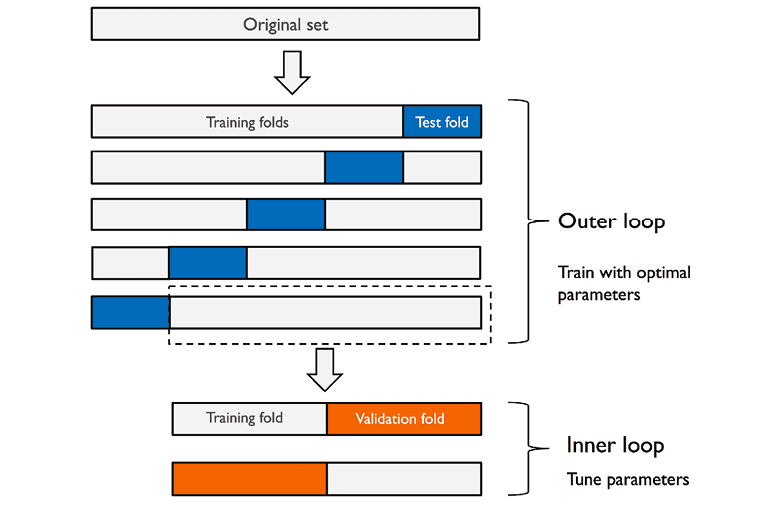

In [ ]:
from sklearn.model_selection import cross_validate

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), [col for col in num_vars if col != 'ejection_fraction']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_vars)
])

# Define model search spaces
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])
ridge_params = {'regressor__alpha': np.logspace(-3, 3, 50)}
ridge_nested = GridSearchCV(ridge_pipeline, ridge_params, cv=5)

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000))
])
lasso_params = {'regressor__alpha': np.logspace(-3, 3, 50)}
lasso_nested = GridSearchCV(lasso_pipeline, lasso_params, cv=5)

# Outer CV for nested evaluation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate nested Ridge
ridge_scores = cross_validate(ridge_nested, X, y, scoring=(
    'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'), cv=outer_cv)

# Evaluate nested Lasso
lasso_scores = cross_validate(lasso_nested, X, y, scoring=(
    'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'), cv=outer_cv)

# Function to format and print results
def summarize_nested_cv(name, scores):
    print(f"\n {name} Nested Cross-Validation Results (5-Fold):")
    mse = -scores['test_neg_mean_squared_error']
    mae = -scores['test_neg_mean_absolute_error']
    r2 = scores['test_r2']

    print(f"  ▸ MSE   : Mean = {mse.mean():.3f}, Std = {mse.std():.3f}")
    print(f"  ▸ MAE   : Mean = {mae.mean():.3f}, Std = {mae.std():.3f}")
    print(f"  ▸ R²    : Mean = {r2.mean():.3f}, Std = {r2.std():.3f}")

# Print summaries
summarize_nested_cv("Ridge", ridge_scores)
summarize_nested_cv("Lasso", lasso_scores)



 Ridge Nested Cross-Validation Results (5-Fold):
  ▸ MSE   : Mean = 77.203, Std = 6.083
  ▸ MAE   : Mean = 6.935, Std = 0.566
  ▸ R²    : Mean = 0.469, Std = 0.053

 Lasso Nested Cross-Validation Results (5-Fold):
  ▸ MSE   : Mean = 73.606, Std = 7.966
  ▸ MAE   : Mean = 6.786, Std = 0.612
  ▸ R²    : Mean = 0.493, Std = 0.072


# Penalized Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Features and target
X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure',
        'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'bmi', 'time', 'ejection_fraction']]
y = df['DEATH_EVENT']

categorical_vars = cat_vars.copy()
categorical_vars.remove('DEATH_EVENT')

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

# Logistic Regression without regularization (penalty='none')
logreg_none_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000))
])


# Logistic Regression (L2)
logreg_l2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000))
])
logreg_l2_params = {'classifier__C': np.logspace(-3, 3, 50)}
logreg_l2_cv = GridSearchCV(logreg_l2_pipeline, logreg_l2_params, cv=5, scoring='roc_auc')

# Logistic Regression (L1)
logreg_l1_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])
logreg_l1_params = {'classifier__C': np.logspace(-3, 3, 50)}
logreg_l1_cv = GridSearchCV(logreg_l1_pipeline, logreg_l1_params, cv=5, scoring='roc_auc')

# Fit models
logreg_l2_cv.fit(X_train, y_train)
logreg_l1_cv.fit(X_train, y_train)
logreg_none_pipeline.fit(X_train, y_train)

print("Best C for Logistic Regression (L2):", logreg_l2_cv.best_params_['classifier__C'])
print("Best C for Logistic Regression (L1):", logreg_l1_cv.best_params_['classifier__C'])

# Predictions
y_pred_none = logreg_none_pipeline.predict(X_test)
y_proba_none = logreg_none_pipeline.predict_proba(X_test)[:, 1]

y_pred_l2 = logreg_l2_cv.predict(X_test)
y_proba_l2 = logreg_l2_cv.predict_proba(X_test)[:, 1]

y_pred_l1 = logreg_l1_cv.predict(X_test)
y_proba_l1 = logreg_l1_cv.predict_proba(X_test)[:, 1]

# Evaluation function
def evaluate_classification(y_true, y_pred, y_proba, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

# Compare metrics
metrics_classif_df = pd.DataFrame([
    evaluate_classification(y_test, y_pred_none, y_proba_none, 'LogReg None'),
    evaluate_classification(y_test, y_pred_l2, y_proba_l2, 'LogReg L2'),
    evaluate_classification(y_test, y_pred_l1, y_proba_l1, 'LogReg L1')
])

print("\nClassification Performance:")
print(metrics_classif_df)

# Coefficient Comparison
feature_names = logreg_l2_cv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'No Reg': [logreg_none_pipeline.named_steps['classifier'].intercept_[0]] +
            list(logreg_none_pipeline.named_steps['classifier'].coef_[0]),
    'L2': [logreg_l2_cv.best_estimator_.named_steps['classifier'].intercept_[0]] +
          list(logreg_l2_cv.best_estimator_.named_steps['classifier'].coef_[0]),
    'L1': [logreg_l1_cv.best_estimator_.named_steps['classifier'].intercept_[0]] +
          list(logreg_l1_cv.best_estimator_.named_steps['classifier'].coef_[0])
})

print("\nCoefficient Comparison:")
print(coef_df)

Best C for Logistic Regression (L2): 0.06866488450043001
Best C for Logistic Regression (L1): 0.1206792640639329

Classification Performance:
         Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  LogReg None      0.85       0.83    0.80      0.82     0.90
1    LogReg L2      0.83       0.86    0.72      0.78     0.90
2    LogReg L1      0.82       0.82    0.72      0.77     0.90

Coefficient Comparison:
                          Feature  No Reg    L2    L1
0                       Intercept   -1.02 -0.51 -0.92
1                        num__age    0.62  0.35  0.23
2   num__creatinine_phosphokinase    0.05  0.04  0.00
3          num__ejection_fraction   -0.43 -0.30 -0.08
4                  num__platelets   -0.18 -0.06  0.00
5           num__serum_creatinine    0.23  0.22  0.00
6               num__serum_sodium    0.03  0.02  0.00
7                        num__bmi    0.57  0.31  0.47
8                       num__time   -1.73 -0.92 -1.06
9                  cat__anaemia_1   -0.24

# CV for KNN

Best k: 10 with macro-f1: 0.9800


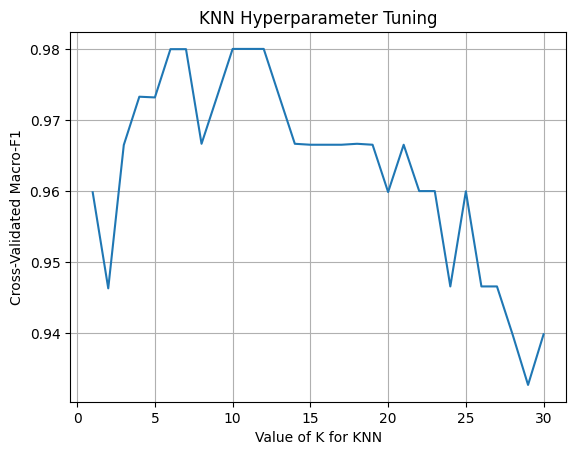

In [ ]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Range of k to try
k_range = range(1, 31)
scores = []

# Cross-validation to find best k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X, y, cv=5, scoring='f1_macro')
    scores.append(cv_scores.mean())

# Best k
best_k = k_range[np.argmax(scores)]
print(f"Best k: {best_k} with macro-f1: {max(scores):.4f}")

# Train final model with best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X, y)

# Optional: plot accuracy vs. k
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Macro-F1')
plt.title('KNN Hyperparameter Tuning')
plt.grid(True)
plt.show()
